<a href="https://colab.research.google.com/github/mingzapingin/deeplabcut_plot/blob/main/deeplabcut_plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Run this Block first using the triangle on the left and upload your .csv file

from google.colab import files
import pandas as pd
import io

uploaded = files.upload()

for fn in uploaded.keys():
  print(f'User uploaded file "{fn}"')
  df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')))
  print(f'Successfully read "{fn}" into a pandas DataFrame named `df`.')
  break # Assuming only one file is uploaded for simplicity. Remove this line if multiple files are expected.

Saving testDLC_Resnet50_ver3Feb5shuffle1_snapshot_best-120.csv to testDLC_Resnet50_ver3Feb5shuffle1_snapshot_best-120.csv
User uploaded file "testDLC_Resnet50_ver3Feb5shuffle1_snapshot_best-120.csv"
Successfully read "testDLC_Resnet50_ver3Feb5shuffle1_snapshot_best-120.csv" into a pandas DataFrame named `df`.


Histogram plot path (not saved): plots/hist_jumps.png


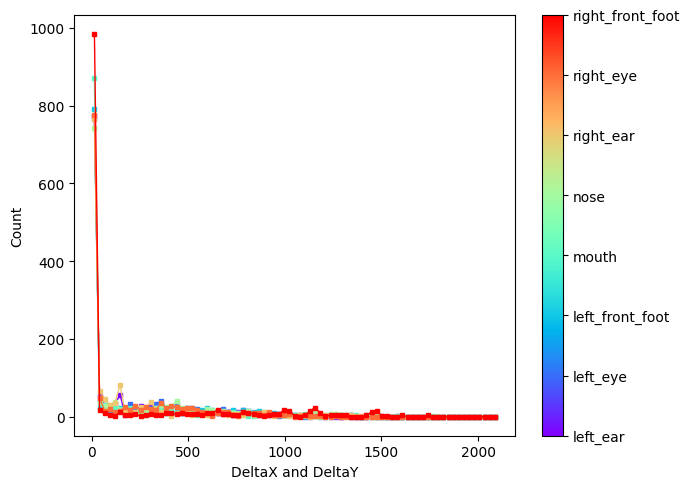

Likelihood plot path (not saved): plots/likelihood.png


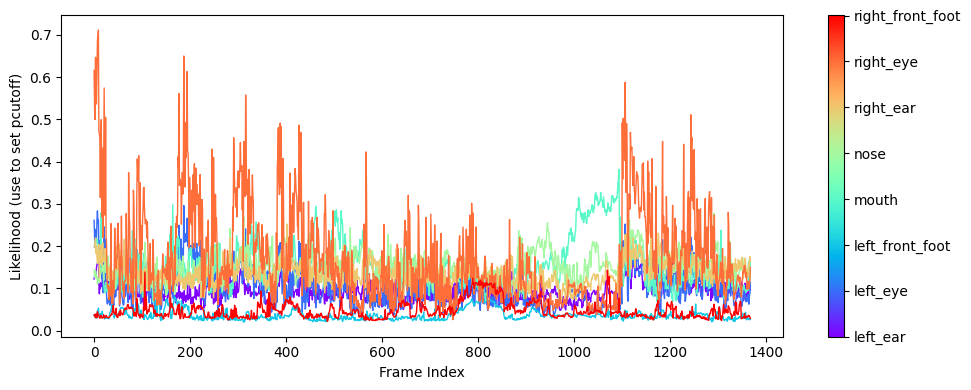

X/Y vs Frame plot path (not saved): plots/xy_vs_frame.png


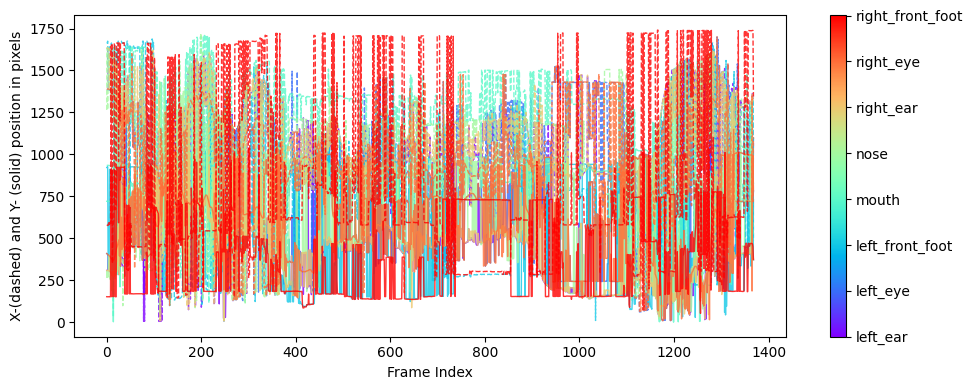

Trajectory plot path (not saved): plots/trajectory.png


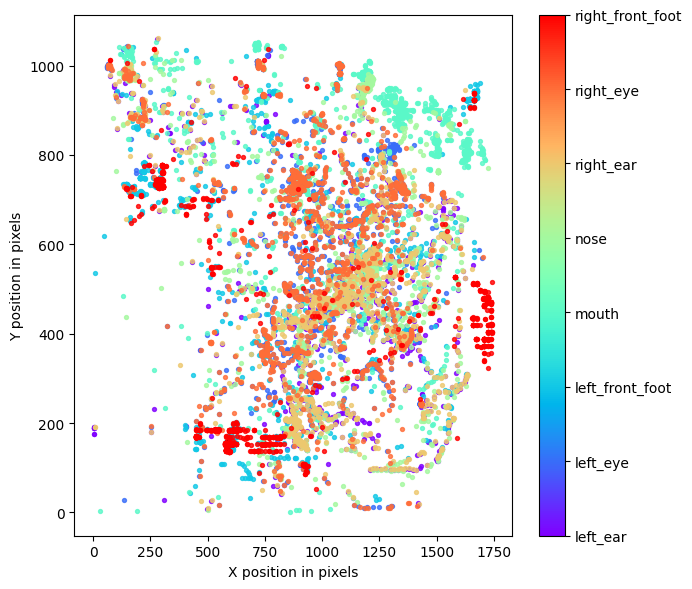

In [ ]:
#Run this Block AFTER you run the first block and Upload your csv file already
#You can see the plot down below and right click to save to your
"""
Make DeepLabCut-style diagnostic plots directly from a DLC .csv file.

Usage:
  python dlc_plot_from_csv.py path/to/DLC.csv --outdir plots --pcutoff 0.9

Outputs:
  - hist_jumps.png
  - likelihood.png
  - xy_vs_frame.png
  - trajectory.png
"""
from __future__ import annotations
import argparse
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib
# Use a non-interactive backend by default (safe for servers/headless)
# matplotlib.use("Agg") # Removed for IPython Notebook style display
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

def _read_dlc_csv(csv_path: str) -> tuple[pd.DataFrame, str, list[str], np.ndarray]:
    df = pd.read_csv(csv_path, header=[0, 1, 2])
    # first column is frame index (usually "scorer/bodyparts/coords")
    frames = pd.to_numeric(df.iloc[:, 0], errors="coerce").to_numpy()
    scorers = [lvl for lvl in df.columns.levels[0] if lvl != "scorer"]
    if not scorers:
        raise ValueError("Could not find a scorer level in the CSV header.")
    scorer = scorers[0]
    bodyparts = [bp for bp in df.columns.levels[1] if bp != "bodyparts"]
    return df, scorer, bodyparts, frames

def _series(df: pd.DataFrame, scorer: str, bp: str, coord: str) -> np.ndarray:
    return pd.to_numeric(df[(scorer, bp, coord)], errors="coerce").to_numpy()

def make_plots(csv_path: str, outdir: str, pcutoff: float | None = None, cmap_name: str = "rainbow") -> dict[str, str]:
    out = Path(outdir)
    out.mkdir(parents=True, exist_ok=True)

    df, scorer, bodyparts, frames = _read_dlc_csv(csv_path)

    cmap = plt.colormaps.get_cmap(cmap_name)
    norm = Normalize(vmin=0, vmax=len(bodyparts) - 1)

    def color_for_bp(bp: str):
        return cmap(norm(bodyparts.index(bp)))

    # 1) Histogram of jump distances (Euclidean distance between consecutive frames)
    bins = np.linspace(0, 2100, 80)
    centers = 0.5 * (bins[:-1] + bins[1:])
    fig, ax = plt.subplots(figsize=(7, 5))
    for bp in bodyparts:
        x = _series(df, scorer, bp, "x")
        y = _series(df, scorer, bp, "y")
        jump = np.sqrt(np.diff(x) ** 2 + np.diff(y) ** 2)
        jump = jump[np.isfinite(jump)]
        counts, _ = np.histogram(jump, bins=bins)
        ax.plot(centers, counts, marker="s", markersize=3, linewidth=1, color=color_for_bp(bp))
    ax.set_xlabel("DeltaX and DeltaY")
    ax.set_ylabel("Count")
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm); sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_ticks(range(len(bodyparts)))
    cbar.set_ticklabels(bodyparts)
    fig.tight_layout()
    hist_path = str(out / "hist_jumps.png")
    # fig.savefig(hist_path, dpi=200) # Save path: hist_jumps.png # Commented out as requested not to save yet
    print(f"Histogram plot path (not saved): {hist_path}") # Print path for context
    plt.show() # Display the plot in IPython Notebook style

    # 2) Likelihood vs frame
    fig, ax = plt.subplots(figsize=(10, 4))
    for bp in bodyparts:
        l = _series(df, scorer, bp, "likelihood")
        ax.plot(frames, l, linewidth=1, color=color_for_bp(bp))
    if pcutoff is not None:
        ax.axhline(pcutoff, linestyle="--", linewidth=1)
    ax.set_xlabel("Frame Index")
    ax.set_ylabel("Likelihood (use to set pcutoff)")
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm); sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_ticks(range(len(bodyparts)))
    cbar.set_ticklabels(bodyparts)
    fig.tight_layout()
    like_path = str(out / "likelihood.png")
    # fig.savefig(like_path, dpi=200) # Save path: likelihood.png # Commented out as requested not to save yet
    print(f"Likelihood plot path (not saved): {like_path}") # Print path for context
    plt.show() # Display the plot in IPython Notebook style

    # 3) X (dashed) and Y (solid) vs frame
    fig, ax = plt.subplots(figsize=(10, 4))
    for bp in bodyparts:
        x = _series(df, scorer, bp, "x")
        y = _series(df, scorer, bp, "y")
        ax.plot(frames, x, linestyle="--", linewidth=1, color=color_for_bp(bp), alpha=0.8)
        ax.plot(frames, y, linestyle="-", linewidth=1, color=color_for_bp(bp), alpha=0.8)
    ax.set_xlabel("Frame Index")
    ax.set_ylabel("X-(dashed) and Y- (solid) position in pixels")
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm); sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_ticks(range(len(bodyparts)))
    cbar.set_ticklabels(bodyparts)
    fig.tight_layout()
    xy_path = str(out / "xy_vs_frame.png")
    # fig.savefig(xy_path, dpi=200) # Save path: xy_vs_frame.png # Commented out as requested not to save yet
    print(f"X/Y vs Frame plot path (not saved): {xy_path}") # Print path for context
    plt.show() # Display the plot in IPython Notebook style

    # 4) Trajectory scatter (x vs y)
    fig, ax = plt.subplots(figsize=(7, 6))
    for bp in bodyparts:
        x = _series(df, scorer, bp, "x")
        y = _series(df, scorer, bp, "y")
        m = np.isfinite(x) & np.isfinite(y)
        ax.scatter(x[m], y[m], s=8, color=color_for_bp(bp), alpha=0.8)
    ax.set_xlabel("X position in pixels")
    ax.set_ylabel("Y position in pixels")
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm); sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_ticks(range(len(bodyparts)))
    cbar.set_ticklabels(bodyparts)
    fig.tight_layout()
    traj_path = str(out / "trajectory.png")
    # fig.savefig(traj_path, dpi=200) # Save path: trajectory.png # Commented out as requested not to save yet
    print(f"Trajectory plot path (not saved): {traj_path}") # Print path for context
    plt.show() # Display the plot in IPython Notebook style

    return {
        "hist_jumps": hist_path,
        "likelihood": like_path,
        "xy_vs_frame": xy_path,
        "trajectory": traj_path,
    }

outputs = make_plots(fn, "plots")